# Land Cover Classification with Python

This notebook demonstrates how to perform **land cover classification** using open-source Python libraries. We will:

- Read and prepare data,
- Train a Random Forest classifier using sample points,
- Validate the model,
- Apply it to an entire image,
- Optionally apply superpixel segmentation (SLIC),
- And optionally convert the final classification to polygons.

You can adapt file paths, band selections, or segmentation parameters as needed.

---


**Step 1: Import Libraries**

We begin by importing all the Python libraries we need throughout this workflow. Each library has a specific purpose:

- `geopandas`, `pandas`: For managing vector data and tabular data structures.
- `rasterio`: Reading and writing raster imagery (GeoTIFF, etc.).
- `sklearn`: Machine-learning algorithms, splitting data, and evaluation metrics.
- `matplotlib`: Visualization and plotting of images and data.
- `numpy`: Core numerical operations on arrays.
- `PIL (ImageColor)`: Converting hex color codes to (R, G, B) format.
- `skimage`: Image segmentation (SLIC) and intensity transformations.
- `scipy`: Statistical functions (e.g., mode).
- `rasterio.features import shapes`: Converting rasters to vector shapes for shapefile export.

These imports should all be installed beforehand via `pip` or `conda`.


In [27]:
# Data handling and analysis
import geopandas as gpd
import pandas as pd
import numpy as np
import json

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Raster handling
import rasterio as rio
from rasterio.enums import Resampling
from rasterio.features import shapes

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

# Utilities
from PIL import ImageColor  # Convert hex color to RGB
import skimage as ski
from skimage.exposure import rescale_intensity
import scipy


**Step 2: Load and Prepare Data**

In this step, we define the file paths for our data sources. Typically, these are:
- A JSON file (`lc.json`) describing land cover classes, their labels, and color palettes.
- A GeoJSON file (`Sample_LC_v1.geojson`) with sample points (training data).
- Two raster datasets:
  1. **PALSAR** (Radar imagery),
  2. **Landsat** (Optical imagery).

We reference these files in subsequent steps to perform classification.


In [28]:
# Paths to data (update these paths to match your environment)
lc_dir = "data/lc.json"  # JSON with land cover information
sample_dir = "data/Sample_LC_v1.geojson"  # GeoJSON sample points
palsar_dir = "https://storage.googleapis.com/gee-ramiqcom-bucket/youtube/lc_python/Palsar_Kerinci_2023_v1.tif"
landsat_dir = "https://storage.googleapis.com/gee-ramiqcom-bucket/youtube/lc_python/Landsat_Kerinci_2023_v1.tif"

**Step 2.1: Load Land Cover Information (JSON)**

1. **Load** the JSON file that contains information about land cover classes (e.g. `values`, `label`, `palette`).
2. Convert to a `pandas.DataFrame` for easy manipulation.
3. Create a `"values_normalize"` column so classes start from 1 instead of 0 or arbitrary codes.
4. Prefix each color in `"palette"` with `"#"`.
5. Build lists and dictionaries to map original -> normalized values, normalized -> label, and color information (both hex and RGB). 
   
These mappings make it easier to reference class names and colors consistently throughout the workflow.


In [29]:
# Load land cover classification JSON
lc = json.load(open(lc_dir))
lc_df = pd.DataFrame(lc)

# Create a column "values_normalize" so each class has a new integer ID (starting at 1)
lc_df["values_normalize"] = lc_df.index + 1

# Make sure palettes have "#" prefix for valid hex color
lc_df["palette"] = "#" + lc_df["palette"]

# Extract lists
values = lc_df["values"].to_list()
values_norm = lc_df["values_normalize"].to_list()
palette = lc_df["palette"].to_list()
labels = lc_df["label"].to_list()

# Create dictionaries for quick reference
dict_values = {}
dict_label = {}
dict_palette_rgb = {}
dict_palette_hex = {}

for i in range(len(values)):
    dict_values[values[i]] = values_norm[i]          # e.g. original->normalized
    dict_label[values_norm[i]] = labels[i]           # e.g. normalized->class label
    dict_palette_rgb[values_norm[i]] = ImageColor.getrgb(palette[i])  # for colormap
    dict_palette_hex[values_norm[i]] = palette[i]                     # for shapefile


In [30]:
from matplotlib.colors import ListedColormap

cmap = ListedColormap(palette)

# Create legend patches
patches = [
    mpatches.Patch(color=palette[i], label=labels[i]) for i in range(len(values))
]
legend = {
    "handles": patches,
    "bbox_to_anchor": (1.05, 1),
    "loc": 2,
    "borderaxespad": 0.0,
}

**Step 2.2: Load Sample Vector Data (GeoJSON)**

1. Read the GeoJSON file containing sample points using `geopandas.read_file()`.
2. Map the original `"lc"` code to our normalized class IDs via `dict_values`.
3. Add an extra `"label"` column for readability.
4. Plot the sample points to visually check distribution.
5. Store everything in `sample_extract` for further manipulation.


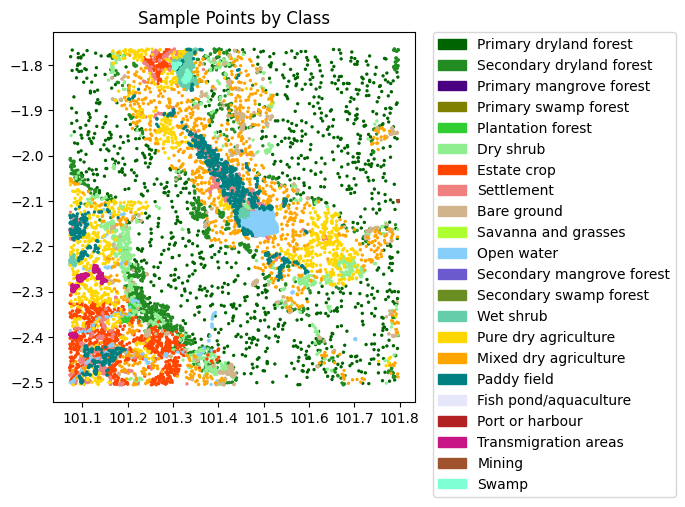

Number of sample points: 14029


In [31]:
# Load the vector samples
sample = gpd.read_file(sample_dir)

# Map the original lc code to the normalized class
sample["value"] = sample["lc"].map(dict_values)
sample["label"] = sample["value"].map(dict_label)

# Plot the samples by color-coded class (optional)
sample.plot(column="value", cmap=cmap, markersize=2)
plt.legend(**legend)
plt.title("Sample Points by Class")
plt.show()

# Create a copy for further processing
sample_extract = sample.copy()

# Extract (x, y) coordinates for raster sampling
coords = [(geom.x, geom.y) for geom in sample_extract.geometry]
print(f"Number of sample points: {sample.shape[0]}")


**Step 3: Load and Visualize Landsat Data**

1. **Open** the Landsat raster with `rasterio`.
2. Read all bands, dividing by `1e4` to scale reflectance.
3. Preview its shape.
4. Construct a **false-color composite** (choosing near-infrared, shortwave-infrared, and red, for example).
5. Rescale intensities for better visualization and plot it.


Landsat image shape: (8, 2751, 2692)


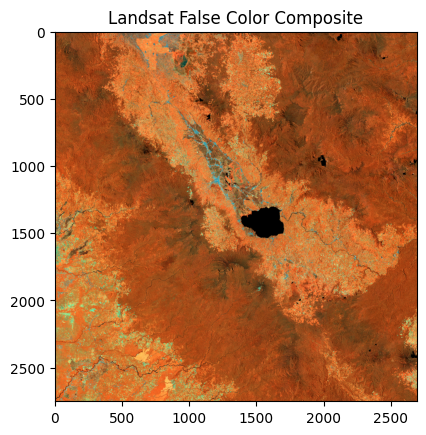

In [32]:
# Open Landsat raster using rasterio
landsat = rio.open(landsat_dir)

# Read all bands and scale (1e4 is a common scale factor for reflectance)
landsat_image = landsat.read() / 1e4
print("Landsat image shape:", landsat_image.shape)  # (band_count, rows, columns)

# Let's create a false color composite for visualization
from skimage.exposure import rescale_intensity

out_range = (0, 1)
red   = rescale_intensity(landsat_image[4],  in_range=(0.1,  0.4),  out_range=out_range)  # e.g. band 5 in real indexing
green = rescale_intensity(landsat_image[5],  in_range=(0.05, 0.3),  out_range=out_range)  # band 6
blue  = rescale_intensity(landsat_image[6],  in_range=(0.025,0.25), out_range=out_range)  # band 7

out_range = (0, 1)
red = rescale_intensity(landsat_image[4], in_range=(0.1, 0.4), out_range=out_range)
green = rescale_intensity(landsat_image[5], in_range=(0.05, 0.3), out_range=out_range)
blue = rescale_intensity(landsat_image[6], in_range=(0.025, 0.25), out_range=out_range)
arr_image = np.stack(
    [red, green, blue]
).T
composite = np.rot90(np.flip(arr_image, 1), 1)

plt.figure()
plt.imshow(composite)
plt.title("Landsat False Color Composite")
plt.show()


**Step 4: Extract Landsat Values for Samples**

Use `rasterio.sample()` to query pixel values at sample coordinates. We then attach these values to the `sample_extract` DataFrame under columns like `"B1"`, `"B2"`, etc. This merges the known labeled points with their Landsat band reflectance values for training.


In [33]:
# Rasterio's sample() returns pixel values at given coordinates
landsat_extract = np.stack([val for val in landsat.sample(coords)]) / 1e4

# Create columns in our sample_extract DataFrame for each band
# (Note: The user included 8 bands [B1..B7,B9], skipping B8 for example.)
sample_extract[["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B9"]] = landsat_extract

sample_extract.head()


,id,lc,geometry,value,label,B1,B2,B3,B4,B5,B6,B7,B9
0,0,2001,POINT (101.67155 -1.86099),1,Primary dryland forest,0.0091,0.0136,0.0321,0.0205,0.2243,0.0994,0.0408,0.0019
1,1,2001,POINT (101.43871 -2.23694),1,Primary dryland forest,0.0101,0.0159,0.0439,0.0292,0.3572,0.1479,0.0560,0.0027
2,2,2001,POINT (101.49341 -1.77152),1,Primary dryland forest,0.0205,0.0223,0.0389,0.0273,0.2772,0.1287,0.0554,0.0033
3,3,2001,POINT (101.75132 -2.02161),1,Primary dryland forest,0.0058,0.0133,0.0385,0.0247,0.2979,0.1405,0.0579,0.0027
4,4,2001,POINT (101.1242 -1.96125),1,Primary dryland forest,0.0174,0.0209,0.0400,0.0252,0.3285,0.1337,0.0543,0.0024


**Step 5: Load and Visualize PALSAR Data**

1. **Open** the PALSAR raster with `rasterio`.
2. **Resample** to match Landsat's dimensions and resolution (bilinear).
3. Scale by `1e3` if needed to get dB values in a workable range.
4. Plot one of the bands (HH) in grayscale to check it.


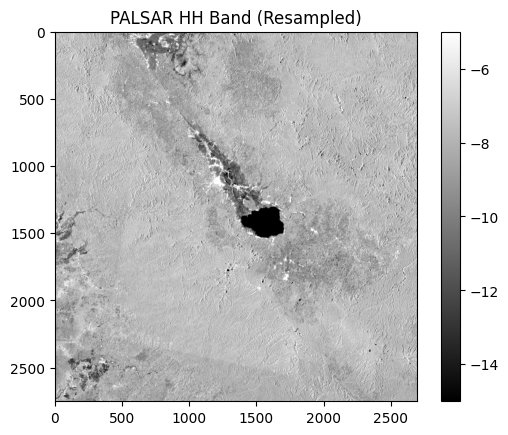

In [34]:
# Open PALSAR data (cloud-hosted in this example)
palsar = rio.open(palsar_dir)

# Resample to match Landsat's shape/resolution (bilinear resampling)
palsar_image = palsar.read(
    out_shape=(palsar.count, landsat_image.shape[1], landsat_image.shape[2]),
    resampling=Resampling.bilinear
) / 1e3

# Visualize the first band (HH polarization) in grayscale
plt.figure()
plt.imshow(palsar_image[0], cmap="gray", vmin=-15, vmax=-5)
plt.title("PALSAR HH Band (Resampled)")
plt.colorbar()
plt.show()


In [35]:
# Extract pixel values at sample coords (now that the images match in size)
palsar_extract = np.stack([val for val in palsar.sample(coords)]) / 1e3

# Create columns for HH and HV in the sample DataFrame
sample_extract[["HH", "HV"]] = palsar_extract

sample_extract.head()


,id,lc,geometry,value,label,B1,B2,B3,B4,B5,B6,B7,B9,HH,HV
0,0,2001,POINT (101.67155 -1.86099),1,Primary dryland forest,0.0091,0.0136,0.0321,0.0205,0.2243,0.0994,0.0408,0.0019,-7.608,-11.281
1,1,2001,POINT (101.43871 -2.23694),1,Primary dryland forest,0.0101,0.0159,0.0439,0.0292,0.3572,0.1479,0.0560,0.0027,-7.931,-11.993
2,2,2001,POINT (101.49341 -1.77152),1,Primary dryland forest,0.0205,0.0223,0.0389,0.0273,0.2772,0.1287,0.0554,0.0033,-7.901,-11.999
3,3,2001,POINT (101.75132 -2.02161),1,Primary dryland forest,0.0058,0.0133,0.0385,0.0247,0.2979,0.1405,0.0579,0.0027,-7.223,-11.135
4,4,2001,POINT (101.1242 -1.96125),1,Primary dryland forest,0.0174,0.0209,0.0400,0.0252,0.3285,0.1337,0.0543,0.0024,-8.136,-12.624


**Step 6: Extract PALSAR Values for Samples**

As with Landsat, we call `rasterio.sample()` at the sample coordinates. We then add columns `"HH"` and `"HV"` to store these radar intensities in `sample_extract`. Now each sample point has both optical and radar data for classification.


,id,lc,geometry,value,label,B1,B2,B3,B4,B5,B6,B7,B9,HH,HV
0,0,2001,POINT (101.67155 -1.86099),1,Primary dryland forest,0.0091,0.0136,0.0321,0.0205,0.2243,0.0994,0.0408,0.0019,-7.608,-11.281
1,1,2001,POINT (101.43871 -2.23694),1,Primary dryland forest,0.0101,0.0159,0.0439,0.0292,0.3572,0.1479,0.0560,0.0027,-7.931,-11.993
2,2,2001,POINT (101.49341 -1.77152),1,Primary dryland forest,0.0205,0.0223,0.0389,0.0273,0.2772,0.1287,0.0554,0.0033,-7.901,-11.999
3,3,2001,POINT (101.75132 -2.02161),1,Primary dryland forest,0.0058,0.0133,0.0385,0.0247,0.2979,0.1405,0.0579,0.0027,-7.223,-11.135
4,4,2001,POINT (101.1242 -1.96125),1,Primary dryland forest,0.0174,0.0209,0.0400,0.0252,0.3285,0.1337,0.0543,0.0024,-8.136,-12.624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14024,14024,50011,POINT (101.32983 -1.83297),22,Swamp,0.0187,0.0235,0.0419,0.0425,0.1372,0.1336,0.0820,0.0026,-12.472,-19.294
14025,14025,50011,POINT (101.33306 -1.82461),22,Swamp,0.0205,0.0240,0.0407,0.0496,0.1509,0.1315,0.0788,0.0027,-11.963,-19.554
14026,14026,50011,POINT (101.33064 -1.8362),22,Swamp,0.0239,0.0278,0.0546,0.0443,0.2668,0.1430,0.0719,0.0023,-9.416,-15.761
14027,14027,50011,POINT (101.30207 -1.80063),22,Swamp,0.0315,0.0407,0.0621,0.0588,0.2338,0.1386,0.0839,0.0031,-10.746,-18.832


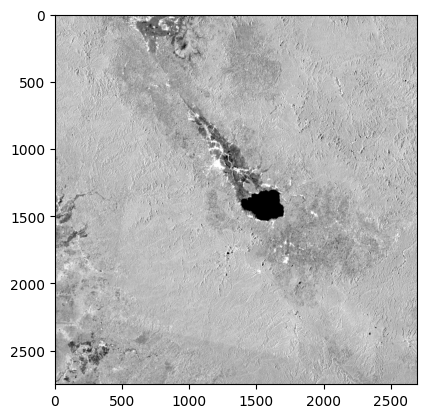

In [36]:
# Plot palsar image
plt.imshow(palsar_image[0], cmap="gray", vmin=-15, vmax=-5)

# Extract raster value
palsar_extract = np.stack([x for x in palsar.sample(coords)]) / 1e3
sample_extract[["HH", "HV"]] = palsar_extract
sample_extract

**Step 7: Train-Test Split**

We split our labeled samples into training (70%) and testing (30%) sets. This step helps avoid overfitting and provides an unbiased estimate of model performance on unseen data.


**Step 8: Model Training (Random Forest)**

1. **Choose** which columns will be used as predictors (e.g., B2..B7, HH, HV).
2. **Instantiate** a `RandomForestClassifier` with 100 trees (`n_estimators=100`).
3. **Fit** the model on the training subset. The model learns relationships between input bands and the known class (`value`).


In [37]:
# Split the sample data for training (70%) and testing (30%)
train, test = train_test_split(sample_extract, train_size=0.7, random_state=2)

print("Training Samples:", train.shape[0])
print("Testing Samples:", test.shape[0])

Training Samples: 9820
Testing Samples: 4209


In [38]:
# Define which columns (bands/features) to use for prediction
predictors = ["B2", "B3", "B4", "B5", "B6", "B7", "HH", "HV"]

# Instantiate the RandomForestClassifier
model = RandomForestClassifier(random_state=42)

# Fit the model on training data
model.fit(
    train[predictors],
    train["value"]
)
print("Model training complete.")


Model training complete.


**Step 9: Model Assessment**

1. Use the trained model to **predict** on the 20% test data.
2. Generate a **confusion matrix** comparing true vs. predicted labels.
3. Display the matrix and a **classification report** (precision, recall, F1-score) for each class.


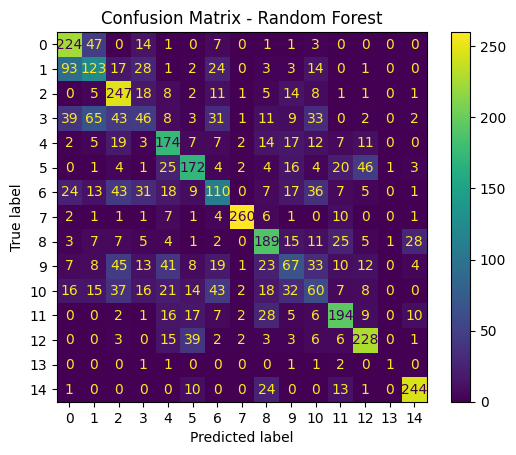

Classification Report:
              precision    recall  f1-score   support

           1       0.55      0.75      0.63       298
           2       0.42      0.40      0.41       309
           5       0.53      0.77      0.63       322
           6       0.26      0.16      0.20       293
           7       0.51      0.62      0.56       280
           8       0.60      0.57      0.59       303
           9       0.41      0.34      0.37       321
          11       0.95      0.88      0.92       295
          14       0.56      0.62      0.59       303
          15       0.33      0.23      0.27       291
          16       0.26      0.21      0.23       289
          17       0.64      0.65      0.65       297
          20       0.69      0.74      0.72       308
          21       0.33      0.14      0.20         7
          22       0.83      0.83      0.83       293

    accuracy                           0.56      4209
   macro avg       0.53      0.53      0.52      4209
wei

In [39]:
# Predict on the test set
test_pred = model.predict(test[predictors])

# Confusion matrix
cm = confusion_matrix(test["value"], test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix - Random Forest")
plt.show()

# Classification report
report = classification_report(test["value"], test_pred)
print("Classification Report:")
print(report)


**Step 10: Apply Model to Full Image**

1. Combine Landsat (8 bands) and PALSAR (2 bands) into one array of shape `(bands, rows, cols)`.
2. **Transpose** to `(rows, cols, bands)` and reshape into `(total_pixels, band_count)`.
3. Use the same `predictors` to classify each pixel.
4. Reshape predictions back to `(rows, cols)` for a land cover map.
5. Display it with `matplotlib`.


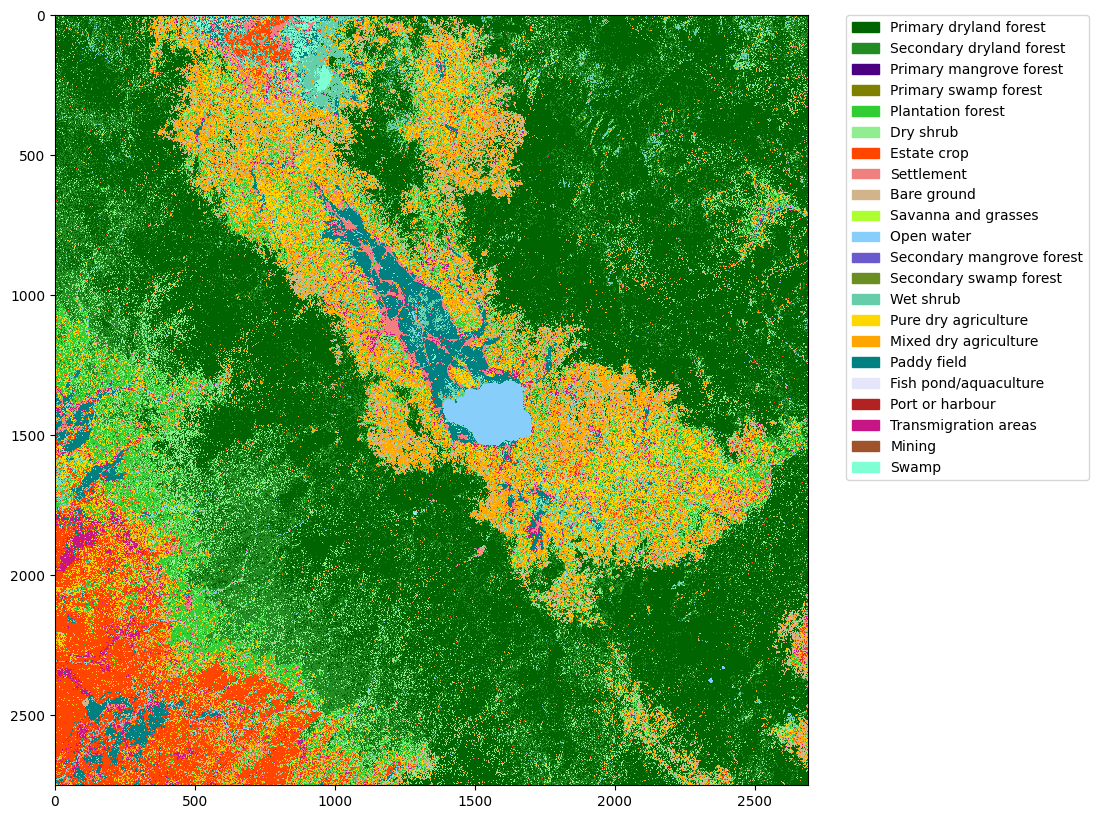

In [44]:
# Load image
combine_image = np.concatenate((landsat_image, palsar_image), 0)
image_transpose = combine_image.T
transpose_shape = image_transpose.shape
table_image = pd.DataFrame(
    image_transpose.reshape(-1, transpose_shape[2]),
    columns=["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B9", "HH", "HV"],
)
table_image
# Predict table image
prediction = model.predict(table_image[predictors])
prediction
# Prediction to image again
prediction_image = np.rot90(np.flip(prediction.reshape(transpose_shape[0], transpose_shape[1]), 1), 1)

# Show to plot
plt.figure(figsize=(10, 10))
plt.imshow(prediction_image, cmap=cmap, interpolation="nearest")
plt.legend(**legend)

**Step 12: Image Segmentation (SLIC)**

Raw classification can appear noisy (salt-and-pepper). **Segmentation** with SLIC groups pixels into superpixels to smooth the classification:

1. Take our composite image (`composite`) as a seed for color-based segmentation.
2. Adjust `n_segments`, `compactness`, and `sigma` as desired.
3. Visualize the segmentation boundaries over the composite.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


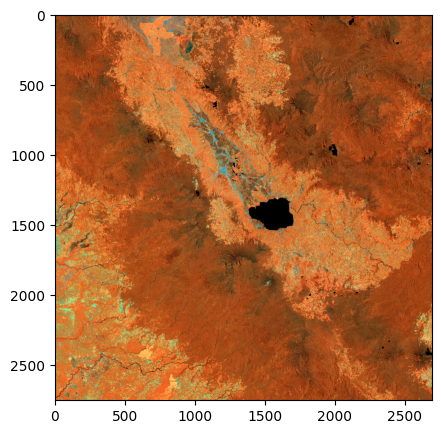

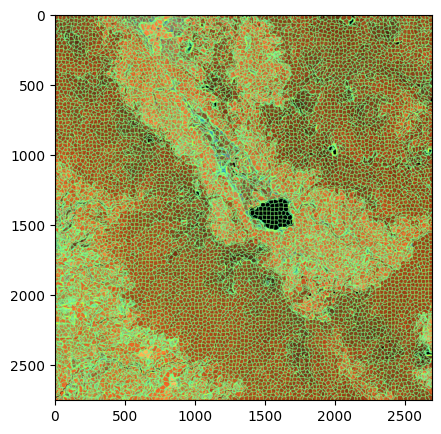

In [45]:
# Image segmentation

# Do uniform filter to composite image
seed_image = composite
plt.figure(figsize=(5, 5))
plt.imshow(seed_image)

# Segmentation
segment = ski.segmentation.slic(
    seed_image, n_segments=10000, compactness=5, sigma=5
)
plt.figure(figsize=(5, 5))
plt.imshow(ski.segmentation.mark_boundaries(composite, segment, outline_color=(0, 255, 255)))

**Step 13: Mode Smoothing per Segment**

1. For each superpixel (unique segment ID), gather the predicted classes from `prediction_image`.
2. Compute the **mode** (most common class) within that segment.
3. Assign this class to all pixels in that segment, effectively smoothing the classification.


In [46]:
# Get the mode of each segment
segment_unique = np.unique(segment)
lc_segment = segment.copy()
for x in segment_unique:
    lc_segment[segment == x] = scipy.stats.mode(prediction_image[segment == x]).mode
lc_segment

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [7, 7, 7, ..., 1, 1, 1],
       [7, 7, 7, ..., 1, 1, 1],
       [7, 7, 7, ..., 1, 1, 1]])

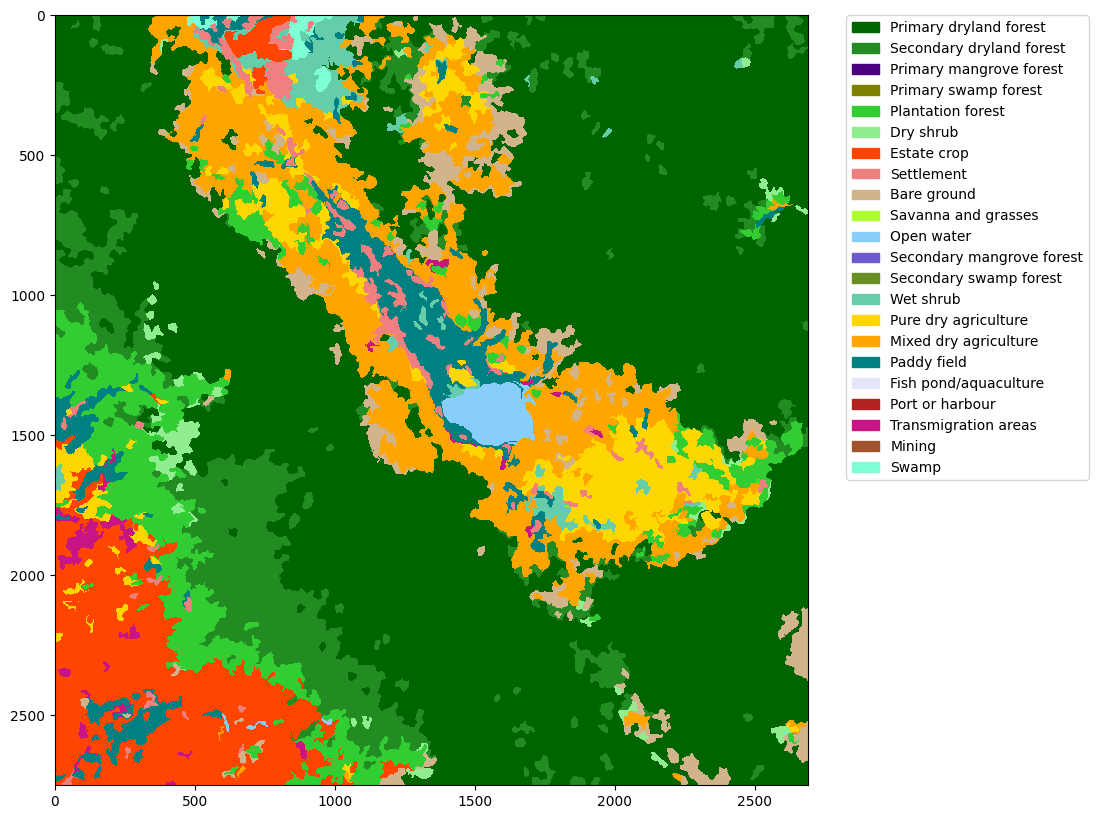

In [47]:
# Show to plot the segmented LC
plt.figure(figsize=(10, 10))
plt.imshow(lc_segment, cmap=cmap, interpolation="nearest")
plt.legend(**legend)

**Step 14: Save Segmented Land Cover (GeoTIFF)**

Similar to Step 11, we write the smoothed classification (`lc_segment`) to a GeoTIFF with an embedded colormap.


In [48]:
# Save image to geotiff
output = rio.open(
    "data/LULC_Segment.tif",
    "w",
    "COG",
    count=1,
    width=lc_segment.shape[1],
    height=lc_segment.shape[0],
    crs=landsat.crs,
    transform=landsat.transform,
    dtype="uint8",
    nodata=0,
    compress="lzw",
    resampling="mode",
    tiled=True,
)
output.write_colormap(1, dict_palette)
output.write(lc_segment, 1)
output.close()

NameError: name 'dict_palette' is not defined

**Step 15: Convert Raster to Shapefile**

If you want polygons representing each contiguous region of classified pixels:

1. `rasterio.features.shapes()` parses an array into `(geometry, value)` pairs.
2. Build a GeoJSON-like dictionary from those features.
3. Convert to a `GeoDataFrame`.
4. Plot or save as a shapefile for downstream analysis.


C:\Users\alvar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pyogrio\raw.py:198: RuntimeWarning: driver GeoJSON does not support open option DRIVER
  return ogr_read(


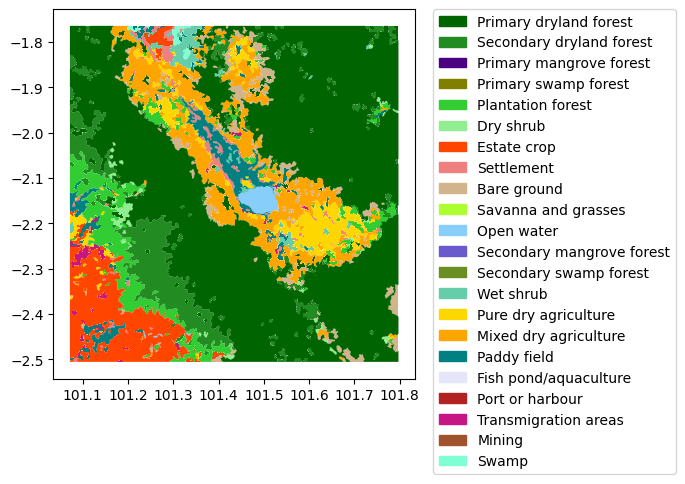

In [49]:
# Convert raster to shapefile
lc_vector = [{ "type": "Feature", "properties": { "lc": x[1] }, "geometry": x[0] } for x in shapes(lc_segment.astype('uint8'), transform=landsat.transform)]
lc_vector = json.dumps({
    "type": "FeatureCollection",
	"properties": {},
	"features": lc_vector
})

# Read as geodataframe
lc_df = gpd.read_file(lc_vector, driver='GeoJSON')

# Plot it
lc_df.plot(column="lc", cmap=cmap)
plt.legend(**legend)

# Add another column such as palette and label
lc_df["palette"] = lc_df["lc"].map(dict_palette_hex)
lc_df["label"] = lc_df["lc"].map(dict_label)

# Save the file
lc_df.to_file("data/LULC_Shapefile.shp")